<a href="https://colab.research.google.com/github/nrajmalwar/Project/blob/master/Session%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist
from skimage import io
import matplotlib.pyplot as plt
from keras import backend as K

# GRADCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet")

dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0709 11:10:05.209495 139829226751872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 11:10:05.235327 139829226751872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 11:10:05.243249 139829226751872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 11:10:05.289862 139829226751872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0709 11:10:07.388768 139829226751872 deprecation_wrapp

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

180


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the results

(-0.5, 223.5, 223.5, -0.5)

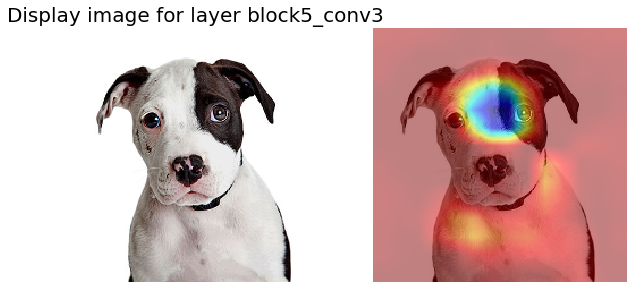

In [0]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)

fig = plt.figure(figsize=(10,10))

sub = fig.add_subplot(1, 2, 1)
sub.imshow(dog)
plt.axis('off')
sub.set_title("Display image for layer block5_conv3", fontsize=20)
sub = fig.add_subplot(1, 2, 2)
sub.imshow(superimposed_img)
plt.axis('off')

# Run an image on last 3 layers

889
889
889


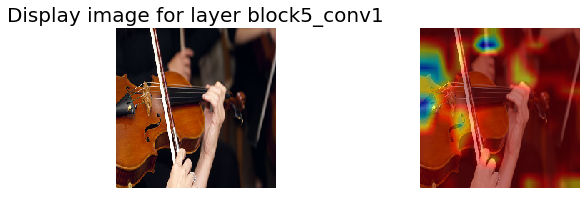

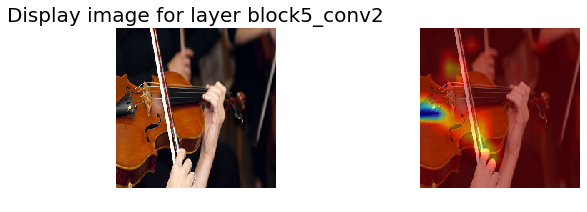

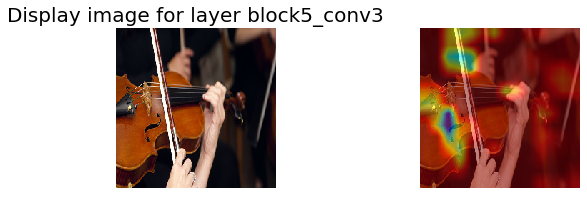

In [0]:
model = VGG16(weights="imagenet")

violin = io.imread("https://www.connollymusic.com/hs-fs/hubfs/First-Violin--Characteristics-of-a-Great-Concert-Master-Blog.jpg?width=1140&name=First-Violin--Characteristics-of-a-Great-Concert-Master-Blog.jpg")
violin = cv2.resize(violin, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(violin)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

for j in range(3):
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("block5_conv" + str(j+1))

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (violin.shape[1], violin.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(violin, 0.5, heatmap, 0.5, 0)

  fig = plt.figure(figsize=(10,10))

  sub = fig.add_subplot(3, 2, 2*j + 1)
  sub.imshow(violin)
  plt.axis('off')
  sub.set_title("Display image for layer block5_conv" + str(j+1), fontsize=20)
  sub = fig.add_subplot(3, 2, 2*j + 2)
  sub.imshow(superimposed_img)
  plt.axis('off')

The model predicts the class id of 889 which corresponds to the class 'violin, fiddle', which is the correct class for our image.

1. In the first layer image, we can see that the hot spot is at several places in the image. It detects the background but also reads some background.
2. In the second layer image, the hot spot has improved and it is now focused at the bottom of the violin.
3. In the third layer image, the hot spot has further improved by focusing on the violin as well as the bow. 

This shows that the GradCAM results show good results for deeper layer as compared to earlier layers.

# Find Sunglasses in the Image

In this part of the assignment, we run GradCAM on an image of Tony Stark (Iron Man). We run the image for last 3 layers of our model. Instead of running model prediction to select to best predicted class, we manually set the class id of our image as 837 which is the label for 'sunglasses, dark glasses, shades'.

In [0]:
!ls

drive  sample_data  tony_stark.png


837
837
837


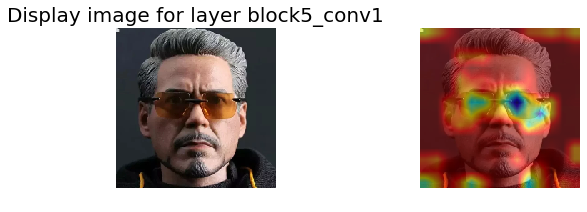

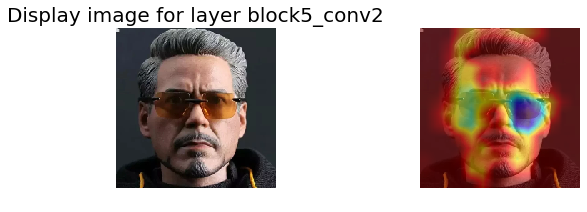

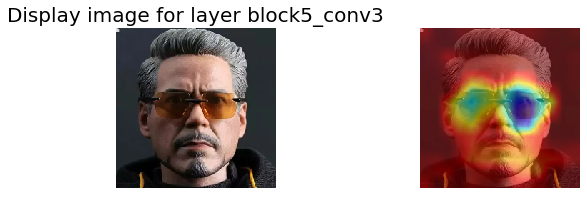

In [0]:
model = VGG16(weights="imagenet")

# Read the image of Tony Stark
tony_stark = io.imread('tony_stark.png')
tony_stark = cv2.resize(tony_stark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tony_stark)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

for j in range(3):
#   preds = model.predict(x)

  # Manually set the class id of the image
  class_idx = 837
  print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("block5_conv" + str(j+1))

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (tony_stark.shape[1], tony_stark.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(tony_stark, 0.5, heatmap, 0.5, 0)
  
  # Display images for last 3 layers of our model
  fig = plt.figure(figsize=(10,10))

  sub = fig.add_subplot(3, 2, 2*j + 1)
  sub.imshow(tony_stark)
  plt.axis('off')
  sub.set_title("Display image for layer block5_conv" + str(j+1), fontsize=20)
  sub = fig.add_subplot(3, 2, 2*j + 2)
  sub.imshow(superimposed_img)
  plt.axis('off')

The GradCAM is able to detect the location of sunglasses in the image when its class id is manually provided.
1. In the first layer image, the hot-spot is scattered around the sunglasses and in the background.
2. In the second layer image, we can see the hot-spot being focused on only the sunglasses.
3. In the third layer image, the hot-spot is dense and focused only around the glasses.



# Part 2 of the Assignment

In this part of the assignment, we refer to the paper https://arxiv.org/pdf/1701.03056.pdf. We explain why Receptive field of the network increases from 29 to 45 in Table 7, Page 21.

Let's first have a look at the table-

In [0]:
from IPython.display import Image

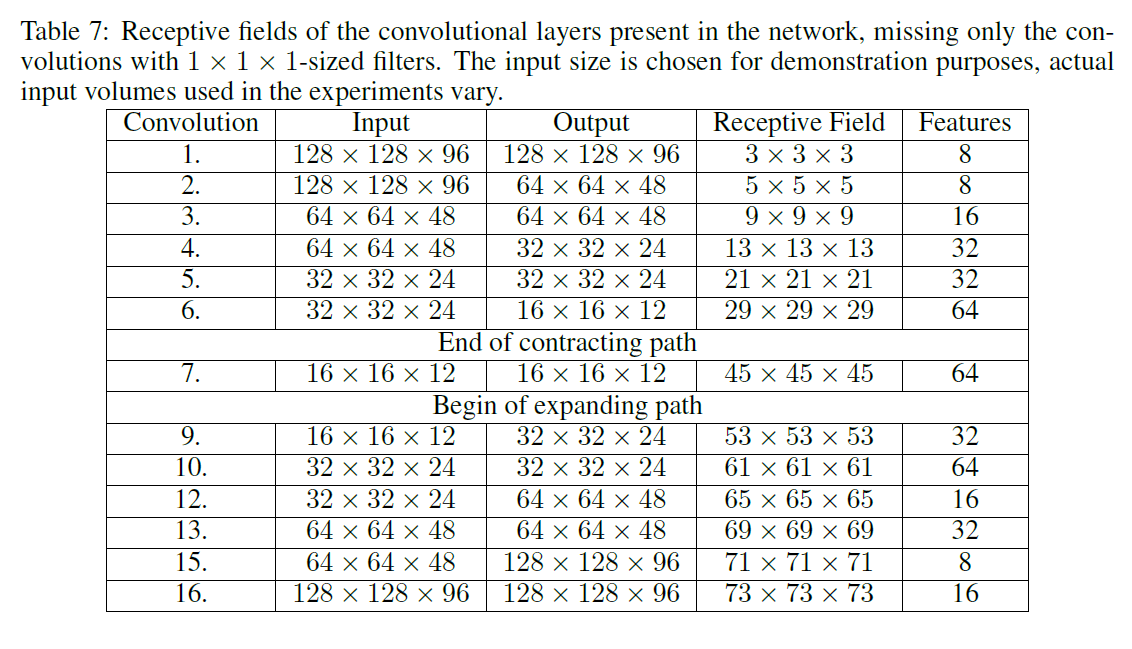

In [0]:
Image('table.PNG', width=700, height=400)

We have numbered the first 7 convolution layers in the model and they are structured as follows-

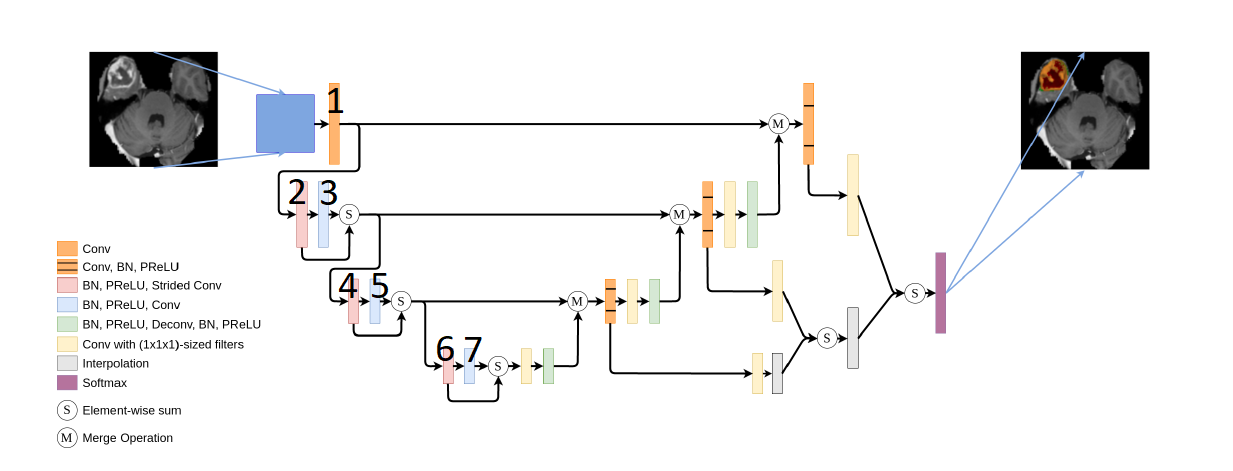

In [0]:
Image('model_diag.png', width=800, height=340)

Layer 2, 4 and 6 have a stride of 2 and rest of the layers have stride 1. All the convolution layers use a kernel size of 3x3. 

We draw a table to calculate the receptive field as follows-

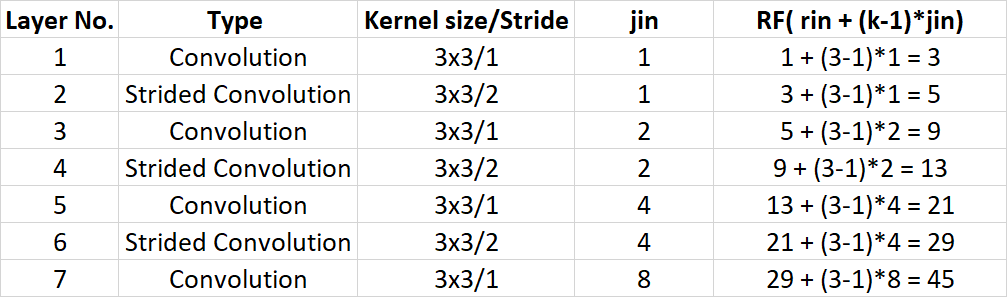

In [6]:
Image('RF_Calculation.png', width=1000, height=300)

Due to the increase in jump-in (jin) value from 4 to 8 in layer 7, the receptive field increases from 29 to 45.